In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt



# Device Configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#Data

In [ ]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import random_split


transform_train = transforms.Compose([
 transforms.RandomCrop(32, padding=4),
 transforms.RandomHorizontalFlip(),
 transforms.ToTensor(),
 transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435,
 0.2616))
])
transform_test = transforms.Compose([
 transforms.ToTensor(),
 transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435,
 0.2616))
])

train_data = datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform_train
)
test_data=datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform_test
)
train_set, val_set = random_split( train_data,[40000, 10000])

train_loader=torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
validation_loader=torch.utils.data.DataLoader(val_set,batch_size=128,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=128,shuffle=False)


100%|██████████| 170498071/170498071 [00:04<00:00, 42577035.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [ ]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


# Model

Residual blocks implementation
> 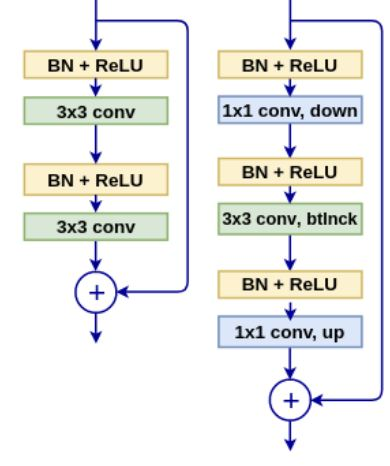



In [ ]:
class PreActivationBlock(nn.Module):
    expansion = 1

    def __init__(self, in_slices, slices, stride=1):
        super(PreActivationBlock, self).__init__()

        self.bn_1 = nn.BatchNorm2d(in_slices)
        self.conv_1 = nn.Conv2d(in_channels=in_slices, out_channels=slices,
                                kernel_size=3, stride=stride, padding=1,
                                bias=False)

        self.bn_2 = nn.BatchNorm2d(slices)
        self.conv_2 = nn.Conv2d(in_channels=slices, out_channels=slices,
                                kernel_size=3, stride=1, padding=1,
                                bias=False)

        # if the input/output dimensions differ use convolution for the shortcut
        if stride != 1 or in_slices != self.expansion * slices:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_slices,
                          out_channels=self.expansion * slices,
                          kernel_size=1,
                          stride=stride,
                          bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn_1(x))

        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x

        out = self.conv_1(out)

        out = F.relu(self.bn_2(out))
        out = self.conv_2(out)

        out += shortcut

        return out

In [ ]:
class PreActivationBottleneckBlock(nn.Module):

    expansion = 4

    def __init__(self, in_slices, slices, stride=1):
        super(PreActivationBottleneckBlock, self).__init__()

        self.bn_1 = nn.BatchNorm2d(in_slices)
        self.conv_1 = nn.Conv2d(in_channels=in_slices, out_channels=slices,
                                kernel_size=1,
                                bias=False)

        self.bn_2 = nn.BatchNorm2d(slices)
        self.conv_2 = nn.Conv2d(in_channels=slices, out_channels=slices,
                                kernel_size=3, stride=stride, padding=1,
                                bias=False)

        self.bn_3 = nn.BatchNorm2d(slices)
        self.conv_3 = nn.Conv2d(in_channels=slices,
                                out_channels=self.expansion * slices,
                                kernel_size=1,
                                bias=False)

        if stride != 1 or in_slices != self.expansion * slices:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_slices,
                          out_channels=self.expansion * slices,
                          kernel_size=1, stride=stride,
                          bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn_1(x))

        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x

        out = self.conv_1(out)

        out = F.relu(self.bn_2(out))
        out = self.conv_2(out)

        out = F.relu(self.bn_3(out))
        out = self.conv_3(out)

        out += shortcut

        return out

ResNet

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        """
        :param block: type of residual block (regular or bottleneck)
        :param num_blocks: a list with 4 integer values.
            Each value reflects the number of residual blocks in the group
        """

        super(ResNet, self).__init__()

        self.in_slices = 64

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64,
                                kernel_size=3, stride=1, padding=1,
                                bias=False)

        self.layer_1 = self._make_group(block, 64, num_blocks[0], stride=1)
        self.layer_2 = self._make_group(block, 128, num_blocks[1], stride=2)
        self.layer_3 = self._make_group(block, 256, num_blocks[2], stride=2)
        self.layer_4 = self._make_group(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_group(self, block, slices, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_slices, slices, stride))
            self.in_slices = slices * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [ ]:
def ResNet34():
  return ResNet(block=PreActivationBlock,num_blocks=[3,4,6,3])
model=ResNet34()
model=model.to(device)

# Defining  Training Loop

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn):
    for epoch in range(n_epochs):

      train_loss=0.0
      model.train()
      for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

      val_loss=0.0
      model.eval()
      for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item()

      print("Epoch: {} /{} Train Loss: {} Val Loss: {}".format(epoch+1,n_epochs, train_loss/len(train_loader), val_loss/len(validation_loader)))



# Training


In [ ]:
optimizer=optim.SGD(model.parameters(),lr=0.005)
loss_fn=nn.CrossEntropyLoss()
training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn)



Epoch: 1 /10 Train Loss: 1.8491863012313843 Val Loss: 1.6700141520439824
Epoch: 2 /10 Train Loss: 1.4805315161665407 Val Loss: 1.437188315995132
Epoch: 3 /10 Train Loss: 1.28999104172277 Val Loss: 1.4083252798152874
Epoch: 4 /10 Train Loss: 1.1403775510315697 Val Loss: 1.4795367159420931
Epoch: 5 /10 Train Loss: 1.02098521218894 Val Loss: 1.1721873034404804
Epoch: 6 /10 Train Loss: 0.93025472750679 Val Loss: 0.9999864199493504
Epoch: 7 /10 Train Loss: 0.8537424421919801 Val Loss: 1.1382262118255035
Epoch: 8 /10 Train Loss: 0.7870662949336603 Val Loss: 0.9248277092281776
Epoch: 9 /10 Train Loss: 0.7308613909319186 Val Loss: 0.8218314700488802
Epoch: 10 /10 Train Loss: 0.6759277571694919 Val Loss: 0.7810759612276584


In [ ]:
num_correct = 0.0
for x_test_batch, y_test_batch in test_loader:
  model.eval()
  y_test_batch = y_test_batch.to(device)
  x_test_batch = x_test_batch.to(device)
  y_pred_batch = model(x_test_batch)
  _, predicted = torch.max(y_pred_batch, 1)
  num_correct += (predicted ==y_test_batch).float().sum()
  accuracy = num_correct/(len(test_loader) *test_loader.batch_size)
print(len(test_loader), test_loader.batch_size)
print("Test Accuracy: {}".format(accuracy))

79 128
Test Accuracy: 0.7319027185440063
